## The models

In [20]:
import argparse

from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

from keras.models import Sequential
from keras.layers import Dense, Flatten, ELU, Activation, Lambda, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers import MaxPooling2D
from keras.optimizers import Adam, RMSprop
from random import randrange
from keras.utils.np_utils import to_categorical

#from common import load_data, load_data_hog, train_and_save_results, L2Penalty

seed=10102016

In [17]:
def get_model_1(learning):
        
    image_shape = (1, 64, 64)

    model = Sequential()
    model.add(Lambda(lambda x: x, input_shape=image_shape, output_shape=image_shape))
    
    model.add(Convolution2D(
        5,
        12, 
        12, 
        init='normal',
        border_mode="valid"))
    model.add(MaxPooling2D())
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(7, init='normal', activation='softmax'))

    optimizer = Adam(lr=learning)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

def get_model_2(learning):
        
    image_shape = (1, 64, 64)

    model = Sequential()
    model.add(Lambda(lambda x: x, input_shape=image_shape, output_shape=image_shape))
    
    model.add(Convolution2D(
        5,
        12, 
        12, 
        init='normal',
        border_mode="valid"))
    model.add(MaxPooling2D())
    model.add(Activation('relu'))

    model.add(Convolution2D(
        10, 
        12,
        12,
        init='normal',
        border_mode="valid"))
    model.add(MaxPooling2D())
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(7, init='normal', activation='softmax'))

    optimizer = Adam(lr=learning)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [18]:
learning_rate = 0.01
model1 = get_model_1(learning_rate)
model2 = get_model_2(learning_rate)

print("Model 1 summary")
model1.summary()

print("*************************************************")
print("Model 2 summary")
model2.summary()

/home/sebastian/miniconda3/envs/mlp/lib/python3.5/site-packages/keras/engine/topology.py:1531: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_3_model" was not an Input tensor, it was generated by layer lambda_3.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: lambda_input_3
  str(x.name))
/home/sebastian/miniconda3/envs/mlp/lib/python3.5/site-packages/keras/engine/topology.py:1531: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_4_model" was not an Input tensor, it was generated by layer lambda_4.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: lambda_input_4
  str(x.name))


Model 1 summary
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
lambda_3 (Lambda)                  (None, 1, 64, 64)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)    (None, 5, 53, 53)   725         lambda_3[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)      (None, 5, 26, 26)   0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
activation_4 (Activation)          (None, 5, 26, 26)   0           maxpooling2d_4[0][0]             
___________________________________________________________________________

## Data

In [19]:
def load_dataset(file_train, file_test, size=1.0):
    data_train = np.loadtxt(file_train, dtype='str', delimiter=',')
    data_test = np.loadtxt(file_test, dtype='str', delimiter=',')
    
    xtr, ytr = data_train[:,1], data_train[:,0].astype(int)
    xte, yte = data_test[:,1], data_test[:,0].astype(int)
    
    # use 15% of train data for testing
    xtr, xva, ytr, yva = train_test_split(xtr, ytr, test_size=0.15, random_state=50)

    if size >= 1.0 and size <=0:
        return xtr, ytr, xva, yva, xte, yte
    
    discard_size = 1.0 - size
    xtr, _, ytr, _ = train_test_split(xtr, ytr, test_size=discard_size, random_state=50)
    xva, _, yva, _ = train_test_split(xva, yva, test_size=discard_size, random_state=50)
    xte, _, yte, _ = train_test_split(xte, yte, test_size=discard_size, random_state=50)
    
    xtr, ytr = reshape_dataset(xtr, ytr.ravel())
    xva, yva = reshape_dataset(xva, yva.ravel())
    xte, yte = reshape_dataset(xte, yte.ravel())
    
#     print(xtr.shape)
#     print(ytr.shape)
    
#     print(xva.shape)
#     print(yva.shape)
    
#     print(xte.shape)
#     print(yte.shape)
    
    return xtr, ytr, xva, yva, xte, yte

def reshape_dataset(x, y):
    # make sure classes are between 0 and num_classes
    new_y = np.ones_like(y)*(-1)
    num_classes = np.unique(y)
    for idx, label in enumerate(num_classes):
        new_y[y == label] = idx
    
    y = to_categorical(new_y)
    
    return x, y

def load_clothes(size=1.0):
    return load_dataset("../data/clothes_train.txt", "../data/clothes_test.txt", size)
    
    
def load_faces(size=1.0):
    return load_dataset("../data/faces_train.txt", "../data/faces_test.txt", size)

# load_faces()
# print("******")
# load_clothes()

## Train

In [42]:
def save_plot_metrics(log_file_name, history):
    keys = history.history.keys()

    f, ax = plt.subplots(len(keys), 1, figsize=(5, 22))

    for idx, k in enumerate(keys):
        ax[idx].plot(history.history[k])
        ax[idx].set_title("model " + k)
        ax[idx].set_ylabel(k)
        ax[idx].set_xlabel('epoch')
    
    f.savefig("{:s}.png".format(log_file_name), dpi=90)

def save_log_metrics(log_file_name, hyper, history):
    header = ""

    for key in hyper:
        header = header + ", " + key + ": " + str(hyper[key])

    header = header[2:]

    with open(log_file_name + ".txt", "w+") as log_file:
        log_file.write(header+"\n")
        
        keys = history.history.keys()
        head = ""
        
        c = 0
        for k in keys:
            if c == 0:
                l = len(history.history[k]) # number of epochs
                h = np.zeros(l)
            head = head + k + ","
            h = np.vstack((h, history.history[k]))
            c = c + 1

        head = head[:-1]
        head = head + "\n"
        log_file.write(head)

        h = h[1:,:]
        h = h.T

        for row in h:
            new_line = ""
            for value in row:
                new_line = new_line + "{:.8f},".format(value)
            new_line = new_line[:-1]
            new_line = new_line + "\n"
            log_file.write(new_line)

    log_file.close()

def generator(X, y, batch_size):
    total_input = len(X)
    
    while True:
        features, targets = [], []
        i = 0
        while len(features) < batch_size:
            index = randrange(0, total_input)
            feats = X[index]
            labels = y[index]

            image = open_image(feats)
                               
            features.append(image)
            targets.append(labels)
            
        yield (np.array(features), np.array(targets))

def getFeaturesTargets(X, y):
    feats = []
    targets = []

    for feat, label in zip(X, y):
        image = open_image(feat)
           
        feats.append(image)
        targets.append(label)

    return np.array(feats), np.array(targets)

def open_image(path):
    image_path = "../data" + path[1:]
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    return image.reshape((1, 64, 64))
           
# arg dataset is 0 for clothes, 1 for faces
def train_model(model, hyper_params, log_file_name, dataset=0, dataset_size=1.0):
    learning_rate = hyper_params["learning_rate"]
    training_size = hyper_params["training_size"]
    batch_size = hyper_params["batch_size"]
    num_epochs = hyper_params["num_epochs"]

    rng = np.random.RandomState(seed)

    #train_data, valid_data, test_data = load_data(rng, batch_size=hyper_params["batch_size"])
    if dataset == 0:
        xtr, ytr, xva, yva, xte, yte = load_clothes(dataset_size)
    else:
        xtr, ytr, xva, yva, xte, yte = load_faces(dataset_size)

    history = model.fit_generator(
        generator(xtr, ytr, batch_size),
        samples_per_epoch = training_size,
        validation_data = getFeaturesTargets(xva, yva),
        nb_epoch = num_epochs
        )
    
    evalx, evaly = getFeaturesTargets(xte, yte)
    eval_ = model.evaluate(evalx, evaly)
    for val, key in zip(eval_, model.metrics_names):
        hyper_params[key] = val

    save_log_metrics(log_file_name, hyper_params, history)
    save_plot_metrics(log_file_name, history)

In [43]:
hyper = OrderedDict()
hyper["learning_rate"] = 0.01
hyper["training_size"] = 2000
hyper["batch_size"] = 50
hyper["num_epochs"] = 1

model1 = get_model_1(hyper["learning_rate"])
model2 = get_model_2(hyper["learning_rate"])

/home/sebastian/miniconda3/envs/mlp/lib/python3.5/site-packages/keras/engine/topology.py:1531: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_21_model" was not an Input tensor, it was generated by layer lambda_21.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: lambda_input_21
  str(x.name))
/home/sebastian/miniconda3/envs/mlp/lib/python3.5/site-packages/keras/engine/topology.py:1531: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_22_model" was not an Input tensor, it was generated by layer lambda_22.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: lambda_input_22
  str(x.name))


### Model1 with clothes

Epoch 1/1
7000/7000 [==============================] - 35s    


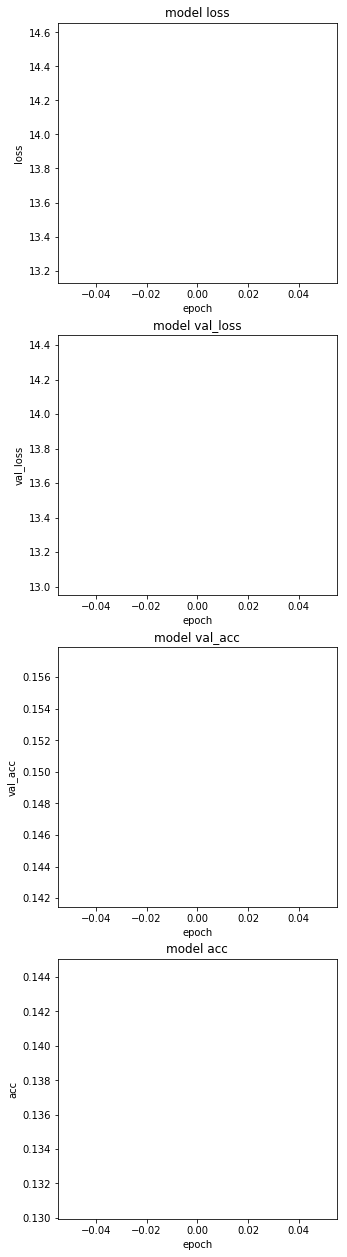

In [44]:
train_model(model1, hyper, "model1_clothes", dataset=0)

### Model1 with faces

In [58]:
train_model(model1, hyper, "model1_faces", dataset=1)

Epoch 1/10
  19/2000 [..............................] - ETA: 19s - loss: 2.8665 - acc: 0.0821

/afs/inf.ed.ac.uk/user/s17/s1700260/miniconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
/afs/inf.ed.ac.uk/user/s17/s1700260/miniconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=(array([[[..., steps_per_epoch=2000, epochs=10)`


2000/2000 [==============================] - 17s - loss: 1.4034 - acc: 0.3872 - val_loss: 1.3603 - val_acc: 0.3853
Epoch 2/10
2000/2000 [==============================] - 18s - loss: 1.3625 - acc: 0.3885 - val_loss: 1.3589 - val_acc: 0.3858
Epoch 3/10
2000/2000 [==============================] - 18s - loss: 1.3607 - acc: 0.3910 - val_loss: 1.3608 - val_acc: 0.3861
Epoch 4/10
2000/2000 [==============================] - 17s - loss: 1.3599 - acc: 0.3915 - val_loss: 1.3626 - val_acc: 0.3869
Epoch 5/10
2000/2000 [==============================] - 16s - loss: 1.3543 - acc: 0.3934 - val_loss: 1.3743 - val_acc: 0.3855
Epoch 6/10
2000/2000 [==============================] - 17s - loss: 1.3551 - acc: 0.3918 - val_loss: 1.3674 - val_acc: 0.3861
Epoch 7/10
2000/2000 [==============================] - 21s - loss: 1.3568 - acc: 0.3940 - val_loss: 1.3709 - val_acc: 0.3858
Epoch 8/10
2000/2000 [==============================] - 19s - loss: 1.3565 - acc: 0.3915 - val_loss: 1.3717 - val_acc: 0.3872
Epo

### Model2 with clothes

In [59]:
train_model(model2, hyper, "model2_clothes", dataset=0)

/afs/inf.ed.ac.uk/user/s17/s1700260/miniconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
/afs/inf.ed.ac.uk/user/s17/s1700260/miniconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=(array([[[..., steps_per_epoch=2000, epochs=10)`


Epoch 1/10
2000/2000 [==============================] - 22s - loss: 0.1915 - acc: 0.9418 - val_loss: 0.1802 - val_acc: 0.9436
Epoch 2/10
2000/2000 [==============================] - 25s - loss: 0.1640 - acc: 0.9509 - val_loss: 0.1656 - val_acc: 0.9429
Epoch 3/10
2000/2000 [==============================] - 26s - loss: 0.1738 - acc: 0.9487 - val_loss: 0.1584 - val_acc: 0.9431
Epoch 4/10
2000/2000 [==============================] - 25s - loss: 0.1681 - acc: 0.9485 - val_loss: 0.2167 - val_acc: 0.9169
Epoch 5/10
2000/2000 [==============================] - 24s - loss: 0.1732 - acc: 0.9480 - val_loss: 0.2195 - val_acc: 0.9327
Epoch 6/10
2000/2000 [==============================] - 23s - loss: 0.1711 - acc: 0.9480 - val_loss: 0.1689 - val_acc: 0.9413
Epoch 7/10
2000/2000 [==============================] - 25s - loss: 0.1716 - acc: 0.9456 - val_loss: 0.2208 - val_acc: 0.9429
Epoch 8/10
2000/2000 [==============================] - 23s - loss: 0.1756 - acc: 0.9494 - val_loss: 0.1868 - val_acc:

### Model2 with faces

In [60]:
train_model(model2, hyper, "model2_faces", dataset=1)

Epoch 1/10
  16/2000 [..............................] - ETA: 23s - loss: 5.4483 - acc: 0.3100

/afs/inf.ed.ac.uk/user/s17/s1700260/miniconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
/afs/inf.ed.ac.uk/user/s17/s1700260/miniconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=(array([[[..., steps_per_epoch=2000, epochs=10)`


2000/2000 [==============================] - 23s - loss: 1.4226 - acc: 0.3778 - val_loss: 1.3649 - val_acc: 0.3889
Epoch 2/10
2000/2000 [==============================] - 20s - loss: 1.3630 - acc: 0.3880 - val_loss: 1.3749 - val_acc: 0.3889
Epoch 3/10
2000/2000 [==============================] - 19s - loss: 1.3652 - acc: 0.3884 - val_loss: 1.3712 - val_acc: 0.3906
Epoch 4/10
2000/2000 [==============================] - 21s - loss: 1.3614 - acc: 0.3916 - val_loss: 1.3758 - val_acc: 0.3881
Epoch 5/10
2000/2000 [==============================] - 24s - loss: 1.3629 - acc: 0.3912 - val_loss: 1.3717 - val_acc: 0.3892
Epoch 6/10
2000/2000 [==============================] - 23s - loss: 1.3573 - acc: 0.3926 - val_loss: 1.3648 - val_acc: 0.3886
Epoch 7/10
2000/2000 [==============================] - 23s - loss: 1.3582 - acc: 0.3916 - val_loss: 1.3841 - val_acc: 0.3883
Epoch 8/10
2000/2000 [==============================] - 21s - loss: 1.3570 - acc: 0.3951 - val_loss: 1.3759 - val_acc: 0.3872
Epo